In [100]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline

####  Stopwords, stemming, and tokenizing

In [59]:
titles = open('/Users/Sri/Desktop/Kaggle/IMDBTop100/title_list.txt').read().split('\n')
titles = titles[:100] # read only top 100


links = open('/Users/Sri/Desktop/Kaggle/IMDBTop100/link_list_imdb.txt').read().split('\n')
links = links[:100]

synopses_wiki = open('/Users/Sri/Desktop/Kaggle/IMDBTop100/synopses_list_wiki.txt').read().split('\n BREAKS HERE')
synopses_wiki = synopses_wiki[:100]

synopses_wiki_clean = []
for text in synopses_wiki:
    text = BeautifulSoup(text,'html.parser').get_text()
    synopses_wiki_clean.append(text)
    
synopses_wiki = synopses_wiki_clean

genres = open('/Users/Sri/Desktop/Kaggle/IMDBTop100/genres_list.txt').read().split('\n')
genres = genres[:100]

print(str(len(titles)) + ' titles')
print(str(len(links)) + ' links')
print(str(len(synopses_wiki)) + ' synopses')
print(str(len(genres)) + ' genres')

100 titles
100 links
100 synopses
100 genres


In [63]:
synopses_imdb = open('/Users/Sri/Desktop/Kaggle/IMDBTop100/synopses_list_imdb.txt').read().split('\n BREAKS HERE')
synopses_imdb = synopses_wiki[:100]

synopses_imdb_clean = []
for text in synopses_imdb:
    text = BeautifulSoup(text, 'html.parser').get_text()
    synopses_imdb_clean.append(text)

synopses_imdb = synopses_imdb_clean

In [65]:
synopses = []
for i in range(len(synopses_wiki)):
    item = synopses_wiki[i] + synopses_imdb[i]
    synopses.append(item)

In [68]:
# generates index for each item in the corpus,, we will use it later
ranks = []

for i in range(0,len(titles)):
    ranks.append(i)

In [72]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')

In [73]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [69]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [93]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in synopses:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [94]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

### Tf-idf and document similarity

In [74]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(synopses)

print(tfidf_matrix.shape)

CPU times: user 8.91 s, sys: 34.6 ms, total: 8.95 s
Wall time: 8.95 s
(100, 218)


In [77]:
terms = tfidf_vectorizer.get_feature_names()

In [79]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)


##### K-means clustering
Using the tf-idf matrix, you can run a slew of clustering algorithms to better understand the hidden structure within the synopses. K-means initializes with a pre-determined number of clusters (I chose 5). Each observation is assigned to a cluster (cluster assignment) so as to minimize the within cluster sum of squares. Next, the mean of the clustered observations is calculated and used as the new cluster centroid. Then, observations are reassigned to clusters and centroids recalculated in an iterative process until the algorithm reaches convergence.

In [81]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 56.5 ms, sys: 346 µs, total: 56.9 ms
Wall time: 58.1 ms


In [84]:
films = { 'title': titles, 'rank': ranks, 'synopsis': synopses, 'cluster': clusters, 'genre': genres }

frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster', 'genre'])

In [86]:
frame.head()

rank                     title  cluster  \
0     0             The Godfather        0   
4     1  The Shawshank Redemption        4   
2     2          Schindler's List        2   
3     3               Raging Bull        3   
1     4                Casablanca        1   

                                     genre  
0                   [u' Crime', u' Drama']  
4                   [u' Crime', u' Drama']  
2  [u' Biography', u' Drama', u' History']  
3    [u' Biography', u' Drama', u' Sport']  
1        [u' Drama', u' Romance', u' War']

In [87]:
frame.cluster.value_counts()

1    26
4    25
3    19
2    19
0    11
dtype: int64

In [90]:
frame['rank'].groupby(frame['cluster']).mean()

cluster
0    45.545455
1    55.038462
2    46.263158
3    46.473684
4    50.240000
Name: rank, dtype: float64

In [98]:

from __future__ import print_function

print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :6]:
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print()
    print()
    print("Cluster %d titles:" % i, end='')
    for title in frame.ix[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print()
    print()

Top terms per cluster:

Cluster 0 words: b'family', b'father', b'son', b'killed', b'york', b'friends',

Cluster 0 titles: The Godfather, The Godfather: Part II, On the Waterfront, Amadeus, Gladiator, Braveheart, Goodfellas, City Lights, The King's Speech, The Grapes of Wrath, Rebel Without a Cause,

Cluster 1 words: b'killed', b'police', b'arrive', b'murders', b'escape', b'returns',

Cluster 1 titles: Casablanca, One Flew Over the Cuckoo's Nest, Titanic, Psycho, Vertigo, West Side Story, Star Wars, The Silence of the Lambs, Chinatown, Unforgiven, Raiders of the Lost Ark, Butch Cassidy and the Sundance Kid, The Treasure of the Sierra Madre, The French Connection, Fargo, Shane, Close Encounters of the Third Kind, The Graduate, Pulp Fiction, Mutiny on the Bounty, The Maltese Falcon, Taxi Driver, Double Indemnity, Rear Window, The Third Man, North by Northwest,

Cluster 2 words: b'army', b'war', b'attacks', b'soldier', b'killed', b'command',

Cluster 2 titles: Schindler's List, Lawrence of

#### Hierarchical document clustering¶

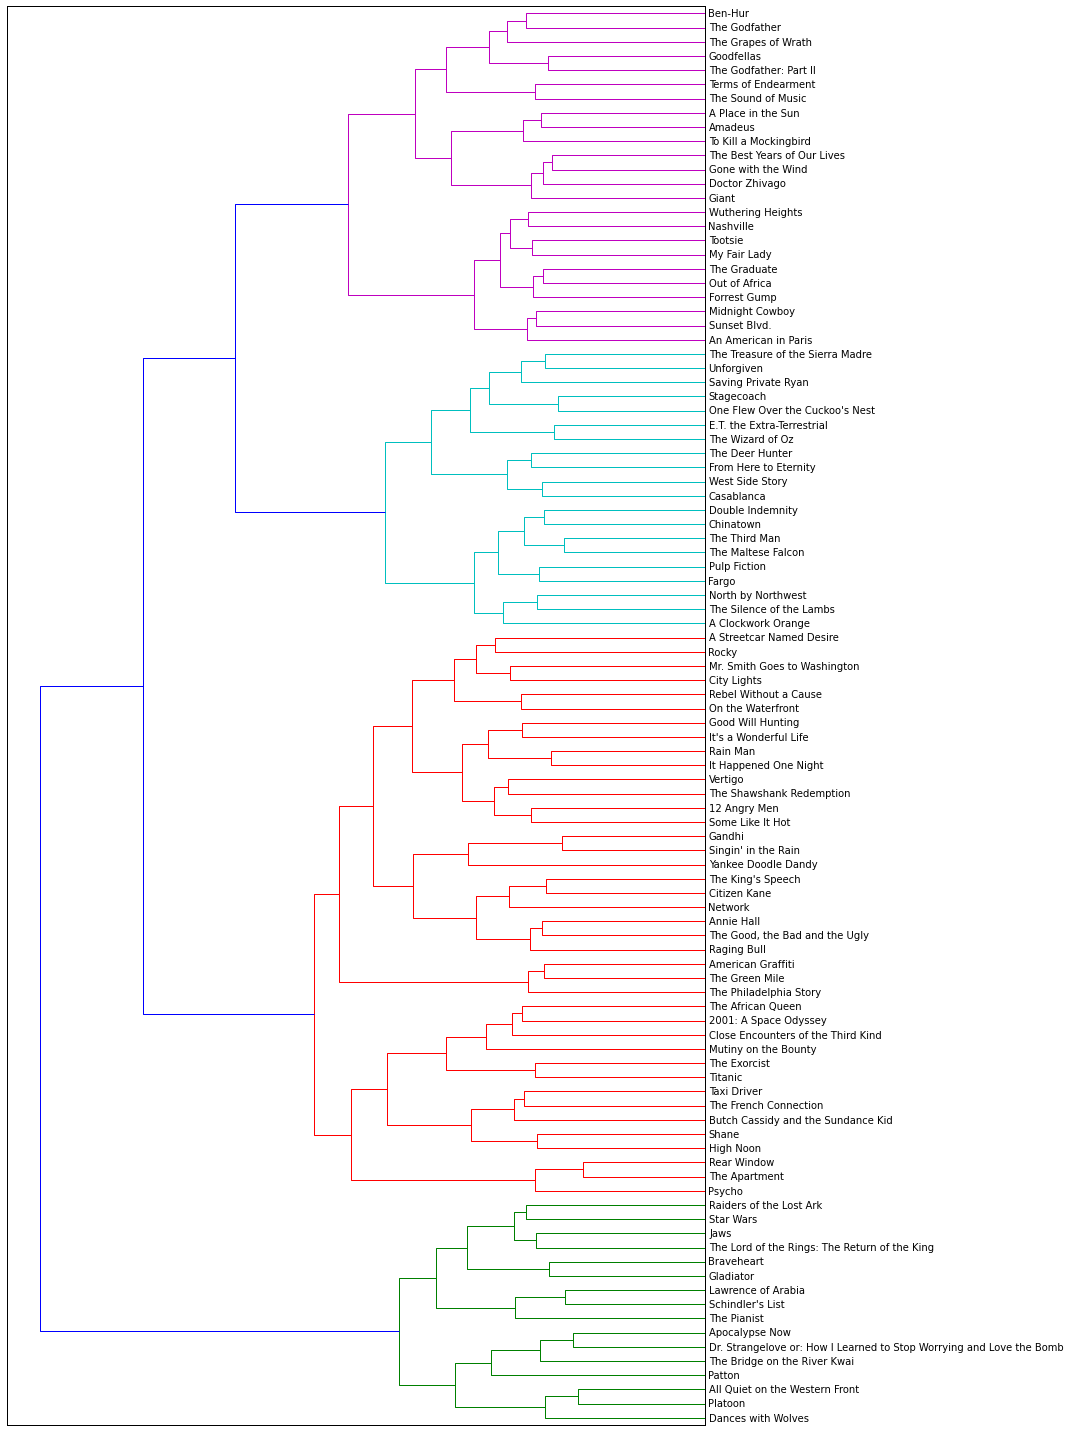

In [107]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')


plt.tight_layout() #show plot with tight layout
